In [1]:
using MATLAB;
using WAV;
using Plots;
using Statistics;
using CuArrays;
using DSP;

In [2]:
function audio_to_V(filename)
    y, Fs = wavread(filename)
    if (size(y,2) == 2);
        y = 0.5*(y[:,1] + y[:,2]);
    end
    f_min = 55.0/(2^(1/36));
    f_max = 7040.0*(2^(1/36))+1e-9;
    S = Dict();
    S["Fs"] = Fs;
    S["cfs"],S["f"],S["g"],S["fshifts"] = mxcall(:cqt,4,y,"SamplingFrequency",Fs,
        "TransformType","full", "FrequencyLimits", [f_min, f_max],"BinsPerOctave", 36.0);
    
    mid_ind = floor(Int64,length(S["f"])/2) - 1;
    V = S["cfs"]["c"][1:mid_ind,:];
    S["phase"] = angle.(V);
    V = abs.(V);    
    
    return V,S;
end;

function V_to_audio(V,S,filename)
    V = V .* exp.(1im*S["phase"]);
    S["cfs"]["c"] = [V; reverse(V,dims=1)];
    y_rec = mxcall(:icqt, 1, S1["cfs"], S1["g"], S1["fshifts"]);
    wavwrite(y_rec, filename, Fs=S["Fs"]);
end;

function nnmf(V,num_components,max_iter)
    num_freq_bins = size(V,1);
    W_h = rand(num_freq_bins,num_components);
    H_h = rand(num_components,size(V,2));
    epsilon1 = cu(1e-9*ones(num_components,size(V,2)));
    epsilon2 = cu(1e-9*ones(num_freq_bins,num_components));
    V = cu(V);
    W = cu(W_h);
    H = cu(H_h);
    for i_iter = 1:max_iter
        H = H .* (W'*V) ./ (W'*W*H .+ epsilon1)
        W = W .* (V*H') ./ (W*H*H' .+ epsilon2)
    end
    W_h = collect(W);
    H_h = collect(H);
    return W_h,H_h
end;

function rearrange_components(W,H)
    
    num_freq = size(W,1);
    num_seq = size(H,2)
    
    # harmonic template
    bins_per_note = 3;
    harmonics = bins_per_note * [0,12,19,24,28];
    penalty = bins_per_note * (1 .+ [0,4,9,16]);
    offset = harmonics[end];
    template = zeros(Float32,2*offset+1);\
    template[penalty] .= -1.0;
    template[1 .+ offset .+ harmonics] .= 1;
    
       
    # find f0 and sort
    f0 = zeros(size(W,2))
    for i_col = 1:size(W,2)
        f0[i_col] = findmax(xcorr(W[:,i_col],template))[2] - length(template)
    end
    f0_ind = sortperm(Int.(f0));
    sort!(f0);

    W = W[:,f0_ind];
    H = H[f0_ind,:];
    # combine components with the same f0
    num_unique_notes = length(unique(f0));
    W2 = zeros(size(W,1),num_unique_notes);
    H2 = zeros(num_unique_notes,size(H,2));
    i_f0 = 1;
    for i_note = 1:num_unique_notes
        W2[:,i_note] = W[:,i_f0];
        H2[i_note,:] = H[i_f0,:];
        if i_f0 < size(W,2)
            while (f0[i_f0] == f0[i_f0+1])
                i_f0 += 1;
                W2[:,i_note] .+= W[:,i_f0];
                H2[i_note,:] .+= H[i_f0,:]
            end
        end
        i_f0 +=1
    end
    
    return W,H,W2,H2
end;

In [3]:
V,S = audio_to_V("data/tetris_piano_poly.wav");

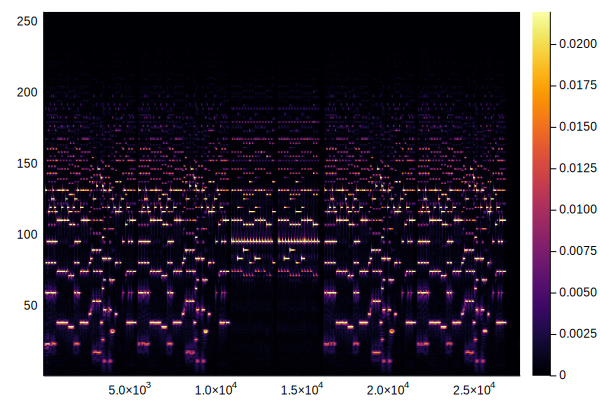

In [4]:
q = quantile(vec(V),0.99);
heatmap(V, clims = (0,q))

In [5]:
num_components = 256;
W, H = nnmf(V,num_components,2048);
W,H,W2,H2 = rearrange_components(W,H);

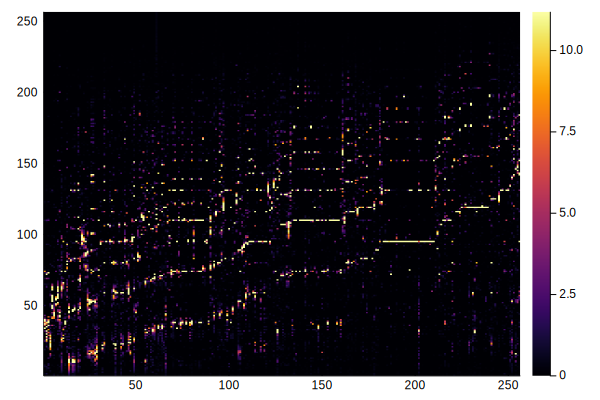

In [6]:
q = quantile(vec(W),0.99);
heatmap(W, clims = (0,q))

In [7]:
split = floor(Int64,num_components/2);
ind1 = 1:split
ind2 = (split+1):num_components;

V1 = W[:,ind1]*H[ind1,:];
V2 = W[:,ind2]*H[ind2,:];

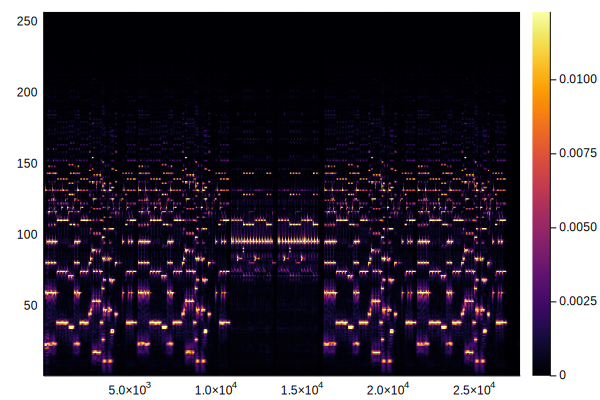

In [8]:
q = quantile(vec(V1),0.99);
heatmap(V1, clims = (0,q))

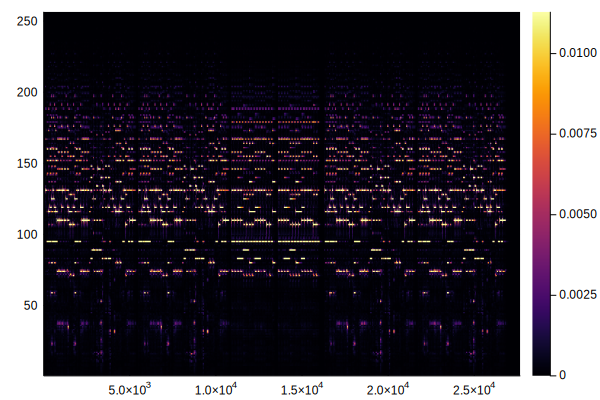

In [9]:
q = quantile(vec(V2),0.99);
heatmap(V2, clims = (0,q))

In [10]:
S1 = copy(S);
S2 = copy(S);
V_to_audio(V1,S1,"test1.wav")
V_to_audio(V2,S2,"test2.wav")